# Deep Kalman Filter 
**Fully-stochastic recurrent-neural network**

## The inference model of a DKF is given by


$$
\begin{aligned}
    p_{\theta_{\bf z}}({\bf z}_t\vert {\bf x}_{1:t-1}, {\bf z}_{1:t-1}, {\bf u}_{1:t-1}) &= p_{\theta_{\bf z}}({\bf z}_t \vert {\bf z}_{t-1}, {\bf u}_t)\\
    p_{\theta_{\bf z}}({\bf x}_t \vert {\bf x}_{1:t-1} z_{1:t}, {\bf u}_{1:t}) &= p_\theta({\bf x}_t \vert {\bf z}_t)
\end{aligned}
$$

In [1]:
import jax
import chex
import jax.numpy as jnp
import matplotlib.pyplot as plt

from functools import partial

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
@chex.dataclass
class Params:
    alpha: float
    beta: float
    delta: float
    gamma: float
    dt: float
    noise: float

In [7]:
def latent_step(z_prev, key, params):
    z1, z2 = z_prev
    noise = jax.random.normal(key) * params.noise * jnp.sqrt(params.dt)
    
    z1_next = params.alpha * z1 - params.beta * z1 * z2
    z2_next = params.delta * z1 * z2 - params.gamma * z2
    z_next = jnp.array([z1_next, z2_next])
    
    z_next = z_prev + params.dt * z_next + noise
    
    return z_next, z_next

def simulate_lv(key, z0, n_steps, params):
    keys = jax.random.split(key, n_steps)
    latent_step_part = partial(latent_step, params=params)
    _, z_hist = jax.lax.scan(latent_step_part, z0, keys)
    return z_hist 


simulate_lv_vmap = jax.vmap(simulate_lv, (0, None, None, None))

In [49]:
n_simulations = 15
n_steps = 10_000
key = jax.random.PRNGKey(314)
keys_sims = jax.random.split(key, n_simulations)
params = Params(alpha=2/3, beta=4/3, delta=1, gamma=1, dt=0.001, noise=0.04)

z_sims = simulate_lv_vmap(keys_sims, z0, n_steps, params)

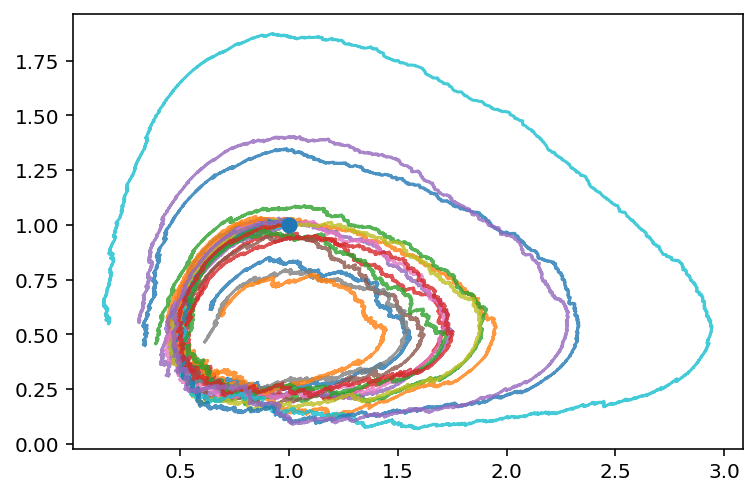

In [50]:
plt.plot(*z_sims.T, alpha=0.8)
plt.scatter(*z0, s=50, zorder=3)

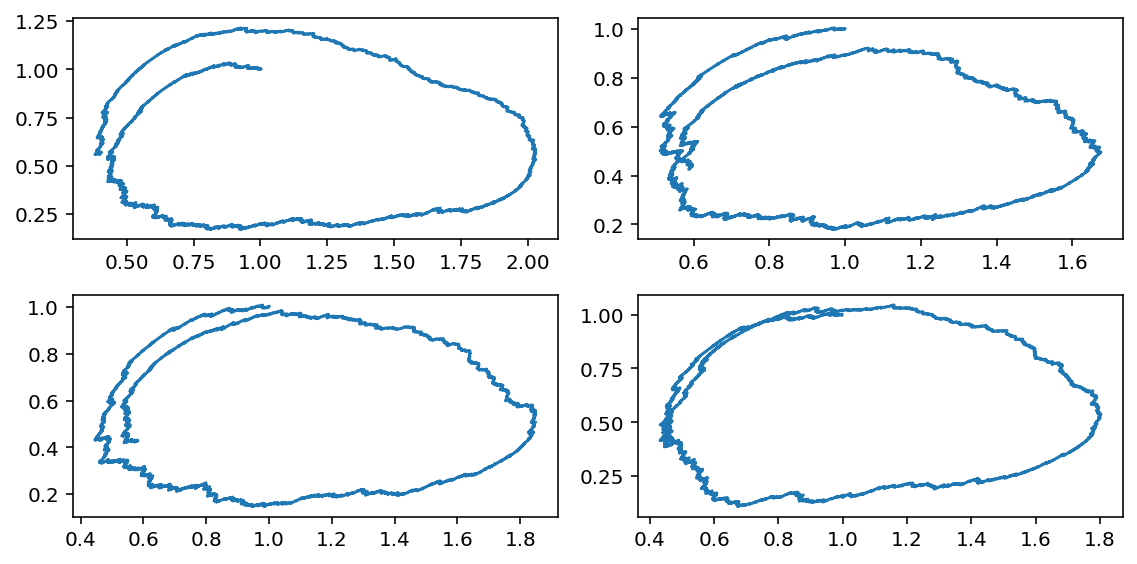

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(8, 4))
axs = axs.ravel()
for ax, z_sim in zip(axs, z_sims):
    ax.plot(*z_sim.T)
plt.tight_layout()

## References

* [Euler-Mayurama method](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method)
* [Lotka-Volterra equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations)